<a href="https://colab.research.google.com/github/jmq19950824/Machine-Learning-with-Python/blob/master/Chapter_7_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

In [0]:
#image size and batch size
img_size=64
batch_size=64

#optimizer parameters
lr=0.0002
beta1=0.5

#training iterations
niter=25
outf='output'

In [3]:
dataset=datasets.CIFAR10(root='data',download=True,transform=
             transforms.Compose([transforms.Resize(img_size),
             transforms.ToTensor(),
             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

dataloader=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)


Extracting data/cifar-10-python.tar.gz to data


In [0]:
#size of latent vector (input vector of generator)
nz=100

#filter size of generator and discriminator
ngf=64
ndf=64

#channels of output images
nc=3

Initialization Weights

In [0]:
#initialization of the weights in generator and discriminator
def weights_init(m):
  classname=m.__class__.__name__
  if classname.find('Conv')!=-1:
    m.weight.data.normal_(0.0,0.02)
  
  elif classname.find('BatchNorm')!=-1:
    m.weight.data.normal_(1.0,0.02)
    m.bias.data.fill_(0)

Generator

In [0]:
class _netG(nn.Module):
  def __init__(self):
    super(_netG,self).__init__()

    self.main=nn.Sequential(
        nn.ConvTranspose2d(nz,ngf*8,4,1,0,bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
        nn.Tanh()
    )

  def forward(self,input):
    output=self.main(input)
    return output

In [21]:
netG=_netG()
netG.apply(weights_init)
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator

In [0]:
class _netD(nn.Module):
  def __init__(self):
    super(_netD,self).__init__()

    self.main=nn.Sequential(
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        nn.Sigmoid()
    )

  def forward(self,input):
    output=self.main(input)
    
    return output.view(-1,1).squeeze(1)

In [23]:
netD=_netD()
netD.apply(weights_init)
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss function

In [0]:
criterion=nn.BCELoss()

input=torch.FloatTensor(batch_size,3,img_size,img_size)
noise=torch.FloatTensor(batch_size,nz,1,1)

fixed_noise=torch.FloatTensor(batch_size,nz,1,1).normal_(0,1)

label=torch.FloatTensor(batch_size)

real_label=1
fake_label=0

In [0]:
if torch.cuda.is_available():
  netD.cuda()
  netG.cuda()
  criterion.cuda()

  input,label=input.cuda(),label.cuda()
  noise,fixed_noise=noise.cuda(),fixed_noise.cuda()

Optimizer

In [0]:
fixed_noise=Variable(fixed_noise)

optimizerG=optim.Adam(netG.parameters(),lr,betas=(beta1,0.999))
optimizerD=optim.Adam(netD.parameters(),lr,betas=(beta1,0.999))

Training

In [28]:
for epoch in range(niter):
  for i,data in enumerate(dataloader,0):
    #training discriminator-with real img
    netD.zero_grad()
    real_cpu,_=data
    batch_size=real_cpu.size(0)

    if torch.cuda.is_available():
      real_cpu=real_cpu.cuda()

    input.resize_as_(real_cpu).copy_(real_cpu)
    label.resize_(batch_size).fill_(real_label)#real_label=1

    inputv=Variable(input)
    labelv=Variable(label)

    output=netD(inputv)
    errD_real=criterion(output,labelv)
    errD_real.backward()

    D_x=output.data.mean()
    #training discriminator-with fake img
    noise.resize_(batch_size,nz,1,1).normal_(0,1)
    noisev=Variable(noise)
    
    fake=netG(noisev)
    labelv=Variable(label.fill_(fake_label))#fake_label=0
    output=netD(fake.detach())
    errD_fake=criterion(output,labelv)
    errD_fake.backward()

    D_G_z1=output.data.mean()

    errD=errD_real+errD_fake
    optimizerD.step()

    #training generator
    netG.zero_grad()
    labelv=Variable(label.fill_(real_label))
    output=netD(fake)

    errG=criterion(output,labelv)
    errG.backward()

    D_G_z2=output.data.mean()
    optimizerG.step()

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data, errG.data, D_x, D_G_z1, D_G_z2))
    
    if i%100==0:
      vutils.save_image(real_cpu,'/content/drive/My Drive/Book Codes/PyTorch深度学习/GAN/real_samples.png',
                        normalize=True)
      fake=netG(fixed_noise)

      vutils.save_image(fake.data,'/content/drive/My Drive/Book Codes/PyTorch深度学习/GAN/fake_samples_epoch_%03d.png'%(epoch),
                normalize=True)

流式输出内容被截断，只能显示最后 5000 行内容。
[18/25][475/782] Loss_D: 0.0761 Loss_G: 7.7764 D(x): 0.9347 D(G(z)): 0.0042 / 0.0011
[18/25][476/782] Loss_D: 0.0971 Loss_G: 6.1962 D(x): 0.9163 D(G(z)): 0.0026 / 0.0045
[18/25][477/782] Loss_D: 0.0472 Loss_G: 4.6040 D(x): 0.9734 D(G(z)): 0.0178 / 0.0194
[18/25][478/782] Loss_D: 0.1164 Loss_G: 5.5361 D(x): 0.9890 D(G(z)): 0.0928 / 0.0062
[18/25][479/782] Loss_D: 0.1047 Loss_G: 5.1082 D(x): 0.9282 D(G(z)): 0.0228 / 0.0117
[18/25][480/782] Loss_D: 0.1119 Loss_G: 5.1677 D(x): 0.9491 D(G(z)): 0.0499 / 0.0130
[18/25][481/782] Loss_D: 0.0962 Loss_G: 4.6806 D(x): 0.9480 D(G(z)): 0.0388 / 0.0150
[18/25][482/782] Loss_D: 0.2033 Loss_G: 6.5484 D(x): 0.9625 D(G(z)): 0.1352 / 0.0024
[18/25][483/782] Loss_D: 0.0868 Loss_G: 6.1589 D(x): 0.9324 D(G(z)): 0.0111 / 0.0032
[18/25][484/782] Loss_D: 0.1433 Loss_G: 3.9994 D(x): 0.8871 D(G(z)): 0.0124 / 0.0296
[18/25][485/782] Loss_D: 0.1343 Loss_G: 5.2522 D(x): 0.9864 D(G(z)): 0.1049 / 0.0081
[18/25][486/782] Loss_D: 0.2130 Loss_G

Visualize the Results

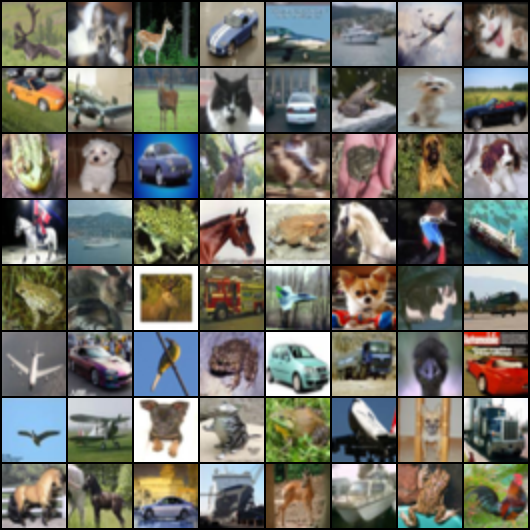

In [3]:
Image.open('/content/drive/My Drive/Book Codes/PyTorch深度学习/GAN/real_samples.png')

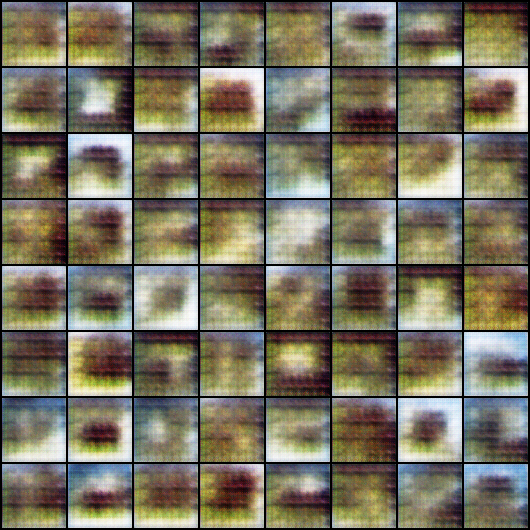

In [4]:
Image.open('/content/drive/My Drive/Book Codes/PyTorch深度学习/GAN/fake_samples_epoch_000.png')

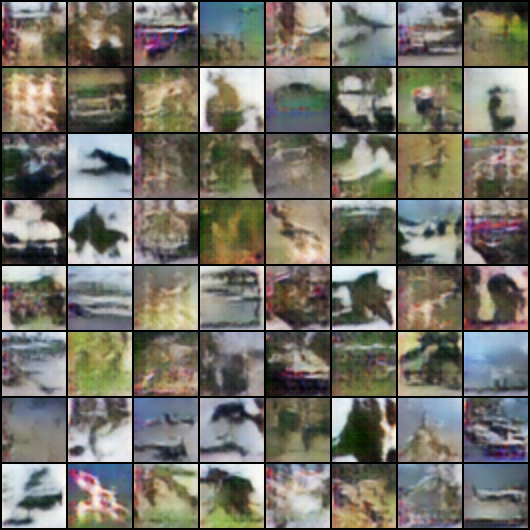

In [5]:
Image.open('/content/drive/My Drive/Book Codes/PyTorch深度学习/GAN/fake_samples_epoch_010.png')

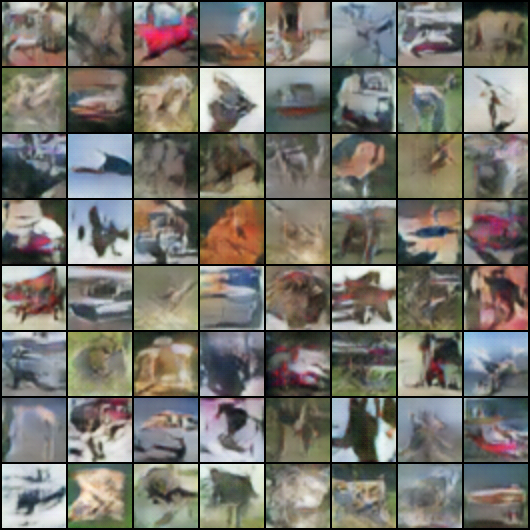

In [6]:
Image.open('/content/drive/My Drive/Book Codes/PyTorch深度学习/GAN/fake_samples_epoch_020.png')

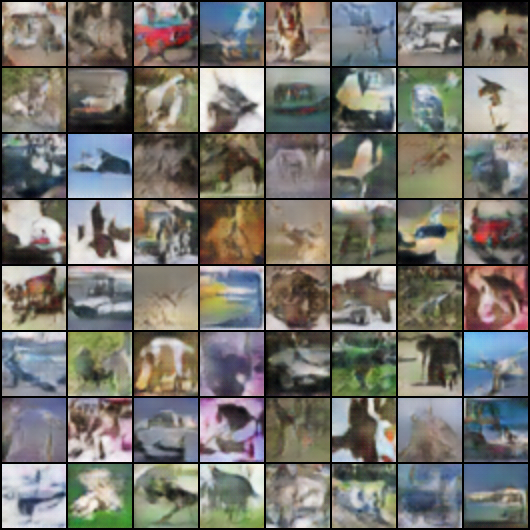

In [7]:
Image.open('/content/drive/My Drive/Book Codes/PyTorch深度学习/GAN/fake_samples_epoch_024.png')